In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### USE WITH COLAB

In [ ]:
import torch
import os
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}",cwd)

checkpoinW2W = torch.load('/content/drive/MyDrive/NLP/nlp2022-hw1-main/model/model_w2w.pt')
checkpoinGLOVE = torch.load('/content/drive/MyDrive/NLP/nlp2022-hw1-main/model/model_glove300.pt')

Current working directory: {0} /content


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class LSTM_Glovo(torch.nn.Module):

    def __init__(self, embedding_dim_Glovo, hidden_dim_Glovo):
        super(LSTM_Glovo, self).__init__()



        #glovo
        self.lstm_glovo = torch.nn.LSTM(embedding_dim_Glovo, hidden_dim_Glovo, batch_first=True,num_layers=2,bidirectional=True,dropout=0.3)



    def forward(self, sentence_glovo):


        lstm_out_glovo, _ = self.lstm_glovo(sentence_glovo)
       

        return lstm_out_glovo

class LSTM_W2W(torch.nn.Module):

    def __init__(self,embedding_dim_w2w, hidden_dim_w2w):
        super(LSTM_W2W, self).__init__()

        #w2w
        self.lstm_w2w = torch.nn.LSTM(embedding_dim_w2w, hidden_dim_w2w, batch_first=True,num_layers=2,bidirectional=True,dropout=0.3)


    def forward(self, sentence_w2w):


        lstm_out_w2w, _ = self.lstm_w2w(sentence_w2w)


        return lstm_out_w2w

class Classifier(torch.nn.Module):

    def __init__(self, embedding_dim_glovo, embedding_dim_w2w, tagset_size):
        super(Classifier, self).__init__()

    


        self.hidden_classifier_0 = torch.nn.Linear(1200,600)
        self.hidden_classifier_1 = torch.nn.Linear(600, tagset_size*tagset_size)
        self.hidden_classifier_2 = torch.nn.Linear(tagset_size*tagset_size, tagset_size)
        self.drop = torch.nn.Dropout(p=0.4)
        self.soft_max = torch.nn.Softmax(dim=2)


    def forward(self, input_glovo, inputw2w):

        input=torch.cat((input_glovo, inputw2w), 2)


        x = self.drop(input)
        x = self.hidden_classifier_0(x)
        x = self.drop(x)
        x = self.hidden_classifier_1(x)
        x = self.drop(x)
        x = self.hidden_classifier_2(x)
        tag_scores=self.soft_max(x)
    


        return tag_scores



model_glovo=LSTM_Glovo(300,300)
model_w2w=LSTM_W2W(300,300)

model_w2w.load_state_dict(checkpoinW2W, strict=False)
model_glovo.load_state_dict(checkpoinGLOVE, strict=False)


model_classifier=Classifier(300,300,13)


In [ ]:
import csv
from typing import Dict, Iterator, List, Union, Optional
from torch.nn.utils.rnn import pad_sequence
import torch
from gensim.models import KeyedVectors
import numpy as np
'''
Input : path to dataset
Output : List of dictionaries, each dictionary is a Id Sentence composed by "sentence" and "labels" field
'''

def dataset_creation(path):
  

  dataset = [] 
  words = []
  labels = []

  with open(path) as file:
      tsv_file = csv.reader(file, delimiter="\t")
      for line in tsv_file:
          
          #print(line)


          if line:


              if line[0] == '#':
                  #print('new line------------------------------')

                  new_sentence={
                      "sentence":words,
                      "labels":labels
                  }
                  
                  dataset.append(new_sentence)
                                  
                  words=[]
                  labels=[]
              else:
                  word=line[0]
                  label=line[1]
                  words.append(word)
                  labels.append(label)

          
  dataset.pop(0)
  return dataset



def vocabulary_and_lableDictionary(data):
    

    PAD_TOKEN = "<PAD>"
    UNK_TOKEN = "<UNK>"

    # vocabulary from word to index
    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    # iterate over the words of the dataset
    for word in [word for sample in data for word in sample["sentence"]]:
        if word not in vocab:
            vocab[word] = len(vocab)

    label_dict = {}
    for label in [label for sample in data for label in sample["labels"]]:
        if label not in label_dict:
            label_dict[label] = len(label_dict)

    #print("Word to Index:")
    #print(vocab)

    #print("Label to Index:")
    #print(label_dict)

    return vocab, label_dict




def load_torch_embedding_layer(weights: KeyedVectors, padding_idx: int = 0, freeze: bool = False):

  vectors = weights.vectors
  # random vector for pad
  pad = np.random.rand(1, vectors.shape[1])
  print(pad.shape)
  # mean vector for unknowns
  unk = np.mean(vectors, axis=0, keepdims=True)
  print(unk.shape)
  # concatenate pad and unk vectors on top of pre-trained weights
  vectors = np.concatenate((pad, unk, vectors))
  # convert to pytorch tensor
  vectors = torch.FloatTensor(vectors)
  # and return the embedding layer
  return torch.nn.Embedding.from_pretrained(vectors, padding_idx=padding_idx, freeze=freeze)

In [ ]:

import os
from pathlib import Path

import torch.nn.functional as F
import torch

#to get the current working directory
current_dir = Path(os.getcwd())





'''
Create Dataset for 
Train
'''
main_dir=current_dir.parent.parent.absolute()
dataset_path=os.path.join(main_dir, "data/train.tsv")
data_train=dataset_creation('/content/drive/MyDrive/NLP/nlp2022-hw1-main/data/train.tsv')
vocab,label_dict=vocabulary_and_lableDictionary(data_train)


'''
Create Dataset for 
Test
'''
dataset_path_dev=os.path.join(main_dir, "data/dev.tsv")
data_test=dataset_creation('/content/drive/MyDrive/NLP/nlp2022-hw1-main/data/dev.tsv')
print('\nYour path for TRAIN dataset is :',dataset_path)
print('\nYour path for DEV dataset is :',dataset_path_dev)


import numpy as np



dict_path_w2w=os.path.join(main_dir, "hw1/data/Dict_W2W.npy")
weight_path_w2w=os.path.join(main_dir, "hw1/data/Weight_W2W.npy")

Dictionary_w2w2 = np.load('/content/drive/MyDrive/NLP/nlp2022-hw1-main/hw1/data/Dict_W2W.npy',allow_pickle='TRUE').item()
weight_w2w = np.load('/content/drive/MyDrive/NLP/nlp2022-hw1-main/hw1/data/Weight_W2W.npy',allow_pickle='TRUE')
weight_tensor_w2w=torch.from_numpy(weight_w2w)


dict_path_glove=os.path.join(main_dir, "hw1/data/Dict_glove.npy")
weight_path_glove=os.path.join(main_dir, "hw1/data/Weight_glove.npy")

Dictionary_glove = np.load('/content/drive/MyDrive/NLP/nlp2022-hw1-main/hw1/data/Dict_Glove.npy',allow_pickle='TRUE').item()
weight_glove = np.load('/content/drive/MyDrive/NLP/nlp2022-hw1-main/hw1/data/Weight_Glove.npy',allow_pickle='TRUE')
weight_tensor_glove=torch.from_numpy(weight_glove)
    





Your path for TRAIN dataset is : /data/train.tsv

Your path for DEV dataset is : /data/dev.tsv


In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch
from typing import Dict, List

# collate fn
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"



def prepare_batch_glove(batch: List[Dict]) -> List[Dict]:
  # extract features and labels from batch
  x = [sample["sentence"] for sample in batch]
  y = [sample["labels"] for sample in batch]
  # convert words to index
  x = [[Dictionary_glove.get(word, Dictionary_glove[UNK_TOKEN]) for word in sample] for sample in x]
  # convert labels to index
  y = [[label_dict.get(label) for label in sample] for sample in y]
  # convert features to tensor and pad them
  x = pad_sequence(
    [torch.as_tensor(sample) for sample in x],
    batch_first=True,
    padding_value=Dictionary_glove.get(PAD_TOKEN)
  )
  # convert and pad labels too
  y = pad_sequence(
    [torch.as_tensor(sample) for sample in y],
    batch_first=True,
    padding_value=0
  )
  return {"x": x, "y": y}





def prepare_batch_w2w(batch: List[Dict]) -> List[Dict]:
  # extract features and labels from batch
  x = [sample["sentence"] for sample in batch]
  y = [sample["labels"] for sample in batch]
  # convert words to index
  x = [[Dictionary_w2w2.get(word, Dictionary_w2w2[UNK_TOKEN]) for word in sample] for sample in x]
  # convert labels to index
  y = [[label_dict.get(label) for label in sample] for sample in y]
  # convert features to tensor and pad them
  x = pad_sequence(
    [torch.as_tensor(sample) for sample in x],
    batch_first=True,
    padding_value=Dictionary_w2w2.get(PAD_TOKEN)
  )
  # convert and pad labels too
  y = pad_sequence(
    [torch.as_tensor(sample) for sample in y],
    batch_first=True,
    padding_value=0
  )
  return {"x": x, "y": y}


def prepare_batch(batch: List[Dict]) -> List[Dict]:
  # extract features and labels from batch
  
  x_ = [sample["sentence"] for sample in batch]
  y = [sample["labels"] for sample in batch]

  # convert words to index
  x1 = [[Dictionary_w2w2.get(word, Dictionary_w2w2[UNK_TOKEN]) for word in sample] for sample in x_]
  x2 = [[Dictionary_glove.get(word, Dictionary_glove[UNK_TOKEN]) for word in sample] for sample in x_]
  # convert labels to index
  y = [[label_dict.get(label) for label in sample] for sample in y]
  # convert features to tensor and pad them
  x1 = pad_sequence(
    [torch.as_tensor(sample) for sample in x1],
    batch_first=True,
    padding_value=Dictionary_w2w2.get(PAD_TOKEN)
  )

    
  x2 = pad_sequence(
    [torch.as_tensor(sample) for sample in x2],
    batch_first=True,
    padding_value=Dictionary_glove.get(PAD_TOKEN)
  )
    

  # convert and pad labels too
  y = pad_sequence(
    [torch.as_tensor(sample) for sample in y],
    batch_first=True,
    padding_value=0
  )
  return {"x": [x1,x2], "y": y}

In [ ]:
from torch.utils.data import DataLoader, Dataset 

#________________________________________________________________________
class NERDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index) -> List[Dict]:
        return self.data[index]
#________________________________________________________________________
class Custom_Embedding():

    def __init__(self, weights, dict, batch, by_id ) -> None:

        self.weights = weights
        self.dict = dict
        self.batch = batch
        self.weights_leng = len(self.weights[0,:])
        self.by_id = by_id
    

    def get_weight(self,token):


        if(self.by_id == False):
            try : index_token = self.dict[token]
            except : 
                #print('missing')
                index_token = self.dict['UNK']
        else:
            return self.weights[token,:]

        
    
        return self.weights[index_token,:]


    def embedd(self,list_words):

        list=[]
        
        if(self.batch == False):

            for word in list_words:
                list.append(self.get_weight(word).tolist())
            

            

            return torch.tensor(list)
        
        elif(self.batch == True):

            max_pad = longest(list_words)
            #print('max padd',max_pad)

            

            for sentence in list_words:

                current_lenght = len(sentence)
                #print('current :',current_lenght)
                sencence=[]
                for word in sentence:
                    sencence.append(self.get_weight(word).tolist())
                
                

                if(max_pad>current_lenght):
                    #print('padding')
                    listofzeros = [0] * self.weights_leng

                    while max_pad>current_lenght:
                        #print('padding now')
                        sencence.append(listofzeros)
                        #print('new leng',len(sencence))
                        current_lenght = len(sencence)
                

                #print('append list',len(sencence))
                list.append(sencence)


            return torch.tensor(list)
#________________________________________________________________________




def longest(list1):
    longest_list = max(len(elem) for elem in list1)
    return longest_list



# data loader parameters
collate_fn_w2w = prepare_batch_w2w # the function that will prepare the data for the model
collate_fn_glove = prepare_batch_glove # the function that will prepare the data for the model
collate_fn = prepare_batch
batch_sizes = 32
num_workers = min(os.cpu_count(), 4)  # it is usually 4 workers per GPU
is_train_dataloader = False # we don"t want to shuffle dev and test data



#NERDdataset for both training and test(from dev.tsv)
train_dataset = NERDataset(data_train)
dev_dataset=NERDataset(data_test)



#DataLoader definition

train_data_loader_glove = DataLoader(
  train_dataset,
  collate_fn=collate_fn_glove,
  shuffle=is_train_dataloader,
  batch_size=batch_sizes,
  num_workers=num_workers,
)



train_data_loader_w2w = DataLoader(
  train_dataset,
  collate_fn=collate_fn_w2w,
  shuffle=is_train_dataloader,
  batch_size=batch_sizes,
  num_workers=num_workers,
)




#collate_fn_w2w or collate_fn_glove
dev_data_loader = DataLoader(
  dev_dataset,
  collate_fn=collate_fn_w2w,
  shuffle=is_train_dataloader,
  batch_size=batch_sizes,
  num_workers=num_workers,
)




train_data_loader = DataLoader(
  train_dataset,
  collate_fn=collate_fn,
  shuffle=is_train_dataloader,
  batch_size=batch_sizes,
  num_workers=num_workers,
)

dev_data_loader = DataLoader(
  dev_dataset,
  collate_fn=collate_fn,
  shuffle=is_train_dataloader,
  batch_size=batch_sizes,
  num_workers=num_workers,
)

        



 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)




model_glovo.to(device)
model_w2w.to(device)
model_classifier.to(device)

cuda:0


Classifier(
  (hidden_classifier_0): Linear(in_features=1200, out_features=600, bias=True)
  (hidden_classifier_1): Linear(in_features=600, out_features=169, bias=True)
  (hidden_classifier_2): Linear(in_features=169, out_features=13, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (soft_max): Softmax(dim=2)
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_classifier.parameters(), lr=0.1, momentum=0.9)
emb_glove = Custom_Embedding(weight_tensor_glove,Dictionary_glove,True,True)
emb_w2w = Custom_Embedding(weight_tensor_w2w,Dictionary_w2w2,True,True)


i=0
loss_history = []
loss_history_val = []


f1_history = []
f1_history_val = []

for epoch in range(50):

  count=0
  accuracy_epoch=0
  total_prediction=[]
  total_labels=[]
  running_loss = 0
  model_classifier.train()
  

  for ext_counter,batch in enumerate(train_data_loader):
    
    
    model_classifier.zero_grad()

    batch_x= batch['x']
    batch_x_w2w = batch_x[0]
    batch_x_g = batch_x[1]

    
    batch_y = batch['y']
    #or is the same
    #batch_y = batch_['y']

    #GLOVE EMBEDDING
    batch_x_g = emb_glove.embedd(batch_x_g.tolist())
    batch_x_w2w = emb_w2w.embedd(batch_x_w2w.tolist())
    #print(batch_x.size())

    
    
    
    input_glovo = batch_x_g.to(device)
    input_w2w = batch_x_w2w.to(device)
    
    with torch.no_grad():
      model_glovo.eval()
      model_w2w.eval()
      prediction_lstm_glovo=model_glovo.forward(input_glovo)
      prediction_lstm_w2w=model_w2w.forward(input_w2w)
      model_glovo.train()
      model_w2w.train()




    prediction = model_classifier.forward(prediction_lstm_glovo,prediction_lstm_w2w)

    #print('Predicted: ',prediction.size())
    #print('Ground Truth: ',batch_y.size())
    sizes=prediction.size()
    #print(sizes[0])
    l0=sizes[0]
    l1=sizes[1]
    l2=sizes[2]
    l3=l0*l1

    new_size = (l3,l2)
    prediction_batch = torch.reshape(prediction,new_size)
    



    
    target_batch = torch.flatten(batch_y)
    target_batch = target_batch.to(device)
    

  

    loss = loss_function(prediction_batch,target_batch)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    


    pre_accu=torch.argmax(prediction_batch, dim=1)
    pre_accu = pre_accu.to('cpu')
    target_batch = target_batch.to('cpu')
  



    #print('predited',pre_accu)
    #print('target',target_batch)


    train_acc = torch.sum(pre_accu == target_batch)


    batch_train_acc = (np.array(train_acc))/(target_batch.size())

    accuracy_epoch=accuracy_epoch+batch_train_acc
    

    
    total_prediction=total_prediction+(pre_accu.tolist())
    total_labels=total_labels+(target_batch.tolist())
    count+=1


    

  

  running_loss_avg = (running_loss/count)
  loss_history.append(running_loss_avg)
  f1_score_epoch = f1_score(total_labels, total_prediction,average=None)
  f1_score_epoch_macro = f1_score(total_labels, total_prediction,average='macro')
  f1_history.append(f1_score_epoch_macro)
  print('\n\nEPOCHS n.'+str(epoch))
  print('______________________TRAIN_______________________________')
  print('f1 score :',f1_score_epoch)
  print('accuracy training :',accuracy_epoch/count)
  print('f1 score macro: ',f1_score_epoch_macro)




  '''
  validation on this epoch
  
  '''
  model_classifier.eval()
  with torch.no_grad():

    count_val=0
    accuracy_epoch_val=0
    total_prediction_val=[]
    total_labels_val=[]
    running_loss_val = 0

    for ext_counter,batch in enumerate(dev_data_loader):

      batch_x= batch['x']
      batch_x_w2w = batch_x[0]
      batch_x_g = batch_x[1]
      
      batch_y = batch['y']
      #or is the same
      #batch_y = batch_['y']

      #GLOVE EMBEDDING
      batch_x_g = emb_glove.embedd(batch_x_g.tolist())
      batch_x_w2w = emb_w2w.embedd(batch_x_w2w.tolist())
      input_glovo = batch_x_g.to(device)
      input_w2w = batch_x_w2w.to(device)



      #print(batch_x.size())
      model_glovo.eval()
      model_w2w.eval()

      prediction_lstm_glovo=model_glovo.forward(input_glovo)
      prediction_lstm_w2w=model_w2w.forward(input_w2w)


      prediction = model_classifier.forward(prediction_lstm_glovo,prediction_lstm_w2w)


      sizes=prediction.size()
      l0=sizes[0]
      l1=sizes[1]
      l2=sizes[2]
      l3=l0*l1
      new_size = (l3,l2)
      prediction_batch = torch.reshape(prediction,new_size)
      target_batch = torch.flatten(batch_y)
      target_batch = target_batch.to(device)
    

      

      loss = loss_function(prediction_batch,target_batch)
      running_loss_val += loss.item()


      pre_accu=torch.argmax(prediction_batch, dim=1)
      pre_accu = pre_accu.to('cpu')
      target_batch = target_batch.to('cpu')
      
      train_acc = torch.sum(pre_accu == target_batch)
      batch_train_acc = (np.array(train_acc))/(target_batch.size())

      accuracy_epoch_val=accuracy_epoch_val+batch_train_acc
      

      
      total_prediction_val=total_prediction_val+(pre_accu.tolist())
      total_labels_val=total_labels_val+(target_batch.tolist())

    
      
      count_val+=1
        


    

    running_loss_val_avg = (running_loss_val/count_val)
    loss_history_val.append(running_loss_val_avg)
    f1_score_epoch_val = f1_score(total_labels_val, total_prediction_val,average=None)
    f1_score_epoch_val_macro = f1_score(total_labels_val, total_prediction_val,average='macro')
    f1_history_val.append(f1_score_epoch_val_macro)
    print('______________________VALIDATION_______________________________')
    print('f1 score :',f1_score_epoch_val)
    print('accuracy training :',accuracy_epoch_val/count_val)
    print('f1 score macro: ',f1_score_epoch_val_macro)












torch.save(model_classifier.state_dict(),'/content/drive/MyDrive/NLP/nlp2022-hw1-main/model/model_classifier.pt')






EPOCHS n.0
______________________TRAIN_______________________________
f1 score : [0.9713276  0.00390016 0.00472813 0.36901099 0.24850205 0.43369694
 0.         0.00475342 0.01315457 0.42480527 0.00408302 0.00433135
 0.0027482 ]
accuracy training : [0.90622726]
f1 score macro:  0.1911570525935559
______________________VALIDATION_______________________________
f1 score : [0.97808097 0.00819672 0.         0.53393665 0.71884058 0.78328982
 0.         0.         0.         0.5876494  0.         0.
 0.        ]
accuracy training : [0.93026746]
f1 score macro:  0.2776918572075572


EPOCHS n.1
______________________TRAIN_______________________________
f1 score : [0.98800634 0.58227297 0.         0.69202824 0.79935467 0.89947427
 0.         0.         0.4732965  0.71816809 0.         0.
 0.23345289]
accuracy training : [0.94890066]
f1 score macro:  0.414311844462056
______________________VALIDATION_______________________________
f1 score : [0.98332822 0.6961326  0.         0.5993266  0.807926

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_classifier.parameters(), lr=0.1, momentum=0.9)
emb_glove = Custom_Embedding(weight_tensor_glove,Dictionary_glove,True,True)
emb_w2w = Custom_Embedding(weight_tensor_w2w,Dictionary_w2w2,True,True)


i=0
loss_history = []
loss_history_val = []


f1_history = []
f1_history_val = []

for epoch in range(50):

  count=0
  accuracy_epoch=0
  total_prediction=[]
  total_labels=[]
  running_loss = 0
  model_classifier.train()
  

  for ext_counter,batch in enumerate(train_data_loader_glove):
    for in_counter,batch_ in enumerate(train_data_loader_w2w):
      


      if(ext_counter==in_counter):

        model_classifier.zero_grad()

        batch_x_g = batch['x']
        batch_x_w2w = batch_['x']

        
        batch_y = batch['y']
        #or is the same
        #batch_y = batch_['y']

        #GLOVE EMBEDDING
        batch_x_g = emb_glove.embedd(batch_x_g.tolist())
        batch_x_w2w = emb_w2w.embedd(batch_x_w2w.tolist())
        #print(batch_x.size())

        
        
        
        input_glovo = batch_x_g.to(device)
        input_w2w = batch_x_w2w.to(device)

        prediction_lstm_glovo=model_glovo.forward(input_glovo)
        prediction_lstm_w2w=model_w2w.forward(input_w2w)








        prediction = model_classifier.forward(prediction_lstm_glovo,prediction_lstm_w2w)

        #print('Predicted: ',prediction.size())
        #print('Ground Truth: ',batch_y.size())
        sizes=prediction.size()
        #print(sizes[0])
        l0=sizes[0]
        l1=sizes[1]
        l2=sizes[2]
        l3=l0*l1

        new_size = (l3,l2)
        prediction_batch = torch.reshape(prediction,new_size)
        



        
        target_batch = torch.flatten(batch_y)
        target_batch = target_batch.to(device)
       

      

        

        loss = loss_function(prediction_batch,target_batch)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        


        pre_accu=torch.argmax(prediction_batch, dim=1)
        pre_accu = pre_accu.to('cpu')
        target_batch = target_batch.to('cpu')
     



        #print('predited',pre_accu)
        #print('target',target_batch)


        train_acc = torch.sum(pre_accu == target_batch)


        batch_train_acc = (np.array(train_acc))/(target_batch.size())

        accuracy_epoch=accuracy_epoch+batch_train_acc
        

        
        total_prediction=total_prediction+(pre_accu.tolist())
        total_labels=total_labels+(target_batch.tolist())
        count+=1


      else:
        pass

  

  running_loss_avg = (running_loss/count)
  loss_history.append(running_loss_avg)
  f1_score_epoch = f1_score(total_labels, total_prediction,average=None)
  f1_score_epoch_macro = f1_score(total_labels, total_prediction,average='macro')
  f1_history.append(f1_score_epoch_macro)
  print('\n\nEPOCHS n.'+str(epoch))
  print('______________________TRAIN_______________________________')
  print('f1 score :',f1_score_epoch)
  print('accuracy training :',accuracy_epoch/count)
  print('f1 score macro: ',f1_score_epoch_macro)




  '''
  validation on this epoch
  
  '''
  model_classifier.eval()
  with torch.no_grad():

    count_val=0
    accuracy_epoch_val=0
    total_prediction_val=[]
    total_labels_val=[]
    running_loss_val = 0

    for ext_counter,batch in enumerate(train_data_loader_glove):
      for in_counter,batch_ in enumerate(train_data_loader_w2w):
      


        if(ext_counter==in_counter):


          batch_x_g = batch['x']
          batch_x_w2w = batch_['x']

          
          batch_y = batch['y']
          #or is the same
          #batch_y = batch_['y']

          #GLOVE EMBEDDING
          batch_x_g = emb_glove.embedd(batch_x_g.tolist())
          batch_x_w2w = emb_w2w.embedd(batch_x_w2w.tolist())
          input_glovo = batch_x_g.to(device)
          input_w2w = batch_x_w2w.to(device)
          #print(batch_x.size())

          
          
          

          prediction_lstm_glovo=model_glovo.forward(input_glovo)
          prediction_lstm_w2w=model_w2w.forward(input_w2w)


          prediction = model_classifier.forward(prediction_lstm_glovo,prediction_lstm_w2w)


          sizes=prediction.size()
          l0=sizes[0]
          l1=sizes[1]
          l2=sizes[2]
          l3=l0*l1
          new_size = (l3,l2)
          prediction_batch = torch.reshape(prediction,new_size)
          target_batch = torch.flatten(batch_y)
          target_batch = target_batch.to(device)
        

          

          loss = loss_function(prediction_batch,target_batch)
          running_loss_val += loss.item()


          pre_accu=torch.argmax(prediction_batch, dim=1)
          pre_accu = pre_accu.to('cpu')
          target_batch = target_batch.to('cpu')
          
          train_acc = torch.sum(pre_accu == target_batch)
          batch_train_acc = (np.array(train_acc))/(target_batch.size())

          accuracy_epoch_val=accuracy_epoch_val+batch_train_acc
          

          
          total_prediction_val=total_prediction_val+(pre_accu.tolist())
          total_labels_val=total_labels_val+(target_batch.tolist())

        
          
          count_val+=1
        

        else:
          pass
    

    running_loss_val_avg = (running_loss_val/count_val)
    loss_history_val.append(running_loss_val_avg)
    f1_score_epoch_val = f1_score(total_labels_val, total_prediction_val,average=None)
    f1_score_epoch_val_macro = f1_score(total_labels_val, total_prediction_val,average='macro')
    f1_history_val.append(f1_score_epoch_val_macro)
    print('______________________VALIDATION_______________________________')
    print('f1 score :',f1_score_epoch_val)
    print('accuracy training :',accuracy_epoch_val/count_val)
    print('f1 score macro: ',f1_score_epoch_val_macro)












torch.save(model_classifier.state_dict(),'/content/drive/MyDrive/NLP/nlp2022-hw1-main/model/model_classifier.pt')




In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/NLP/nlp2022-hw1-main/model/model_classifier.pt')

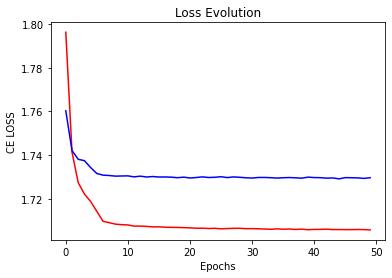

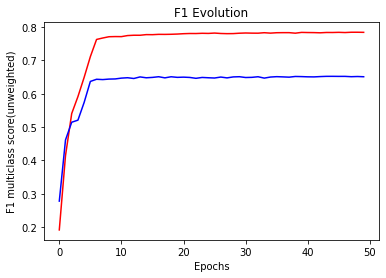

In [ ]:
#Plot accuracy
#NB: my accuracy is "drogata" dalla presenza del padding 
#Padding elements are classified as 0,  class 0 is then more populated and because is accuracy is always above 0.9 tha final accuracy results more high then reality
#In order to check is the model is Overfitting and limit the effect of padding on loss/accuracy results i am using the f_1 results on both train and 
plt.figure()

plt.subplot(111)
plt.title('Loss Evolution')
plt.plot(np.array(loss_history), 'r',np.array(loss_history_val),'b')
plt.ylabel('CE LOSS')
plt.xlabel('Epochs')
plt.show()



plt.subplot(111)
plt.title('F1 Evolution')
plt.plot(np.array(f1_history), 'r',np.array(f1_history_val),'b')
plt.ylabel('F1 multiclass score(unweighted)')
plt.xlabel('Epochs')
plt.show()